In [1]:
from torchsummary import summary
import os
import pandas as pd
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor,ToTensor, ToPILImage, Compose, InterpolationMode,Normalize
from sklearn.model_selection import train_test_split
import wandb
import cv2
import albumentations as A
from utils.seg_dataset import SegmentationDataset
from utils.custom_dataset import CustomDataset
from utils.test_dataset import TestDataset
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
train_dir_path="./data/train/train/"
label_dir_path="./data/train_gt/train_gt/"
test_dir_path="./data/test/test/"
transform=Compose([Resize((256,256),interpolation=InterpolationMode.BILINEAR),
                   ToTensor()])

In [6]:
dataset=SegmentationDataset(train_dir_path,label_dir_path,transform)

In [12]:
TRAIN_SIZE=0.9
BATCH_SIZE=8
img_data=[]
label_data=[]

In [13]:
for x,y in dataset:
    img_data.append(x)
    label_data.append(y)

In [14]:
temp_X_train,temp_X_val,temp_y_train,temp_y_val=train_test_split(img_data,label_data,train_size=TRAIN_SIZE,random_state=10)

In [15]:
print(len(temp_X_train))
print(len(temp_X_val))

900
100


In [121]:
train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(80, 120), eps=None, always_apply=False, p=0.3),
    A.RGBShift(p=0.3, r_shift_limit=0.04, g_shift_limit=0.04, b_shift_limit=0.04),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],max_pixel_value=1)
])
val_augmentation=A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],max_pixel_value=1)])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20220\1176767809.py:4: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(80, 120), eps=None, always_apply=False, p=0.3),


In [65]:
train_set=CustomDataset(temp_X_train,temp_y_train,aug=train_augmentation)
val_set=CustomDataset(temp_X_val,temp_y_val,aug=val_augmentation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


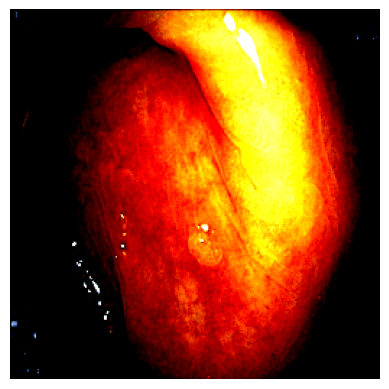

In [136]:
t=train_set[4][0]
image = t.permute(1, 2, 0).numpy()

# Step 2: Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axis for cleaner display
plt.show()

In [137]:
train_dataloader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader=DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=True)

In [138]:
model=smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3   
)
model=model.to(device)

In [139]:
wandb.init(
    project="Polyp Detection",
    resume="allow",
)
wandb.watch(model)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nzd (nzd-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


[]

In [ ]:
EPOCH=100
lr=0.0001
PATH="model/model.pth"
criterion=DiceLoss(mode="multiclass")
optimizer=optim.Adam(model.parameters(),lr=lr)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5,patience=5,min_lr=0.00001)

In [141]:
def train():
    best_val_loss=999
    for epoch in range(EPOCH):
        model.train()
        train_loss=0
        start_time=time.time()
        for i,(data,target) in enumerate(train_dataloader):
            data,target=data.to(device),target.to(device)
            output=model(data)
            loss=criterion(output,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()
        time_taken=time.time()-start_time
        model.eval()
        val_loss=0
        with torch.no_grad():
            for i,(data,target) in enumerate(val_dataloader):
                data,target=data.to(device),target.to(device)
                output=model(data)
                loss=criterion(output,target)
                val_loss+=loss.item()
        train_loss=train_loss/len(train_dataloader.dataset)
        val_loss=val_loss/len(val_dataloader.dataset)
        print(f"Done epoch {epoch}: | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Time taken: {time_taken:.4f} |")
        if val_loss<best_val_loss:
            best_val_loss=val_loss
            checkpoint={
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': val_loss,
            }
            torch.save(checkpoint,PATH)
        wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        })
    wandb.finish()

In [142]:
train()

Done epoch 0: | Train loss: 0.0735 | Val loss: 0.0702 | Time taken: 20.1948 |
Done epoch 1: | Train loss: 0.0570 | Val loss: 0.0530 | Time taken: 19.1914 |
Done epoch 2: | Train loss: 0.0470 | Val loss: 0.0485 | Time taken: 19.1999 |
Done epoch 3: | Train loss: 0.0388 | Val loss: 0.0342 | Time taken: 19.2491 |
Done epoch 4: | Train loss: 0.0331 | Val loss: 0.0367 | Time taken: 19.1467 |
Done epoch 5: | Train loss: 0.0299 | Val loss: 0.0308 | Time taken: 19.1739 |
Done epoch 6: | Train loss: 0.0286 | Val loss: 0.0234 | Time taken: 19.1589 |
Done epoch 7: | Train loss: 0.0296 | Val loss: 0.0281 | Time taken: 19.2378 |
Done epoch 8: | Train loss: 0.0252 | Val loss: 0.0298 | Time taken: 19.5031 |
Done epoch 9: | Train loss: 0.0282 | Val loss: 0.0335 | Time taken: 19.2328 |
Done epoch 10: | Train loss: 0.0261 | Val loss: 0.0304 | Time taken: 19.1777 |
Done epoch 11: | Train loss: 0.0262 | Val loss: 0.0290 | Time taken: 19.2604 |
Done epoch 12: | Train loss: 0.0260 | Val loss: 0.0266 | Time 

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
train_loss,█▇▅▅▅▄▅▄▄▄▄▃▄▃▃▂▄▂▃▃▃▂▂▂▃▂▂▂▁▁▂▂▃▂▂▂▁▂▂▁
val_loss,█▂▂▁▃▃▃▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▃▃▂▂▁▂▁▁▃▃▃▃▂▂▂▃▁
epoch,149
train_loss,0.01077
val_loss,0.02055


In [143]:
checkpoint=torch.load(PATH)
model.load_state_dict(checkpoint["model"])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20220\1763826793.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load(PATH)


<All keys matched successfully>

In [144]:
test_transform=Compose([Resize((256,256),interpolation=InterpolationMode.BILINEAR),
                   ToTensor(),Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
test_dataset=TestDataset(test_dir_path,test_transform)
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)
predict_dir_path="./data/test/predicted_mask/"

In [145]:
def predict():
    model.eval()
    with torch.no_grad():
        for i, (img,path,h,w) in enumerate(test_dataloader):
            img=img.to(device)
            mask=model(img)
            for j in range(len(img)):
                img_name=path[j].split("/")[-1].split(".")[0]
                file_name=img_name+".png"
                one_hot_mask=(F.one_hot(torch.argmax(mask[j], 0)).permute(2,0,1).float()) #convert mask to image
                one_hot_mask[2,:,:]=0 #convert blue to black
                mask2image=ToPILImage()(one_hot_mask)
                final_image=Resize((h[j].item(), w[j].item()), interpolation=InterpolationMode.NEAREST)(mask2image) #resize to original size
                save_path=os.path.join(predict_dir_path,file_name)
                final_image.save(save_path)
                

In [146]:
predict()

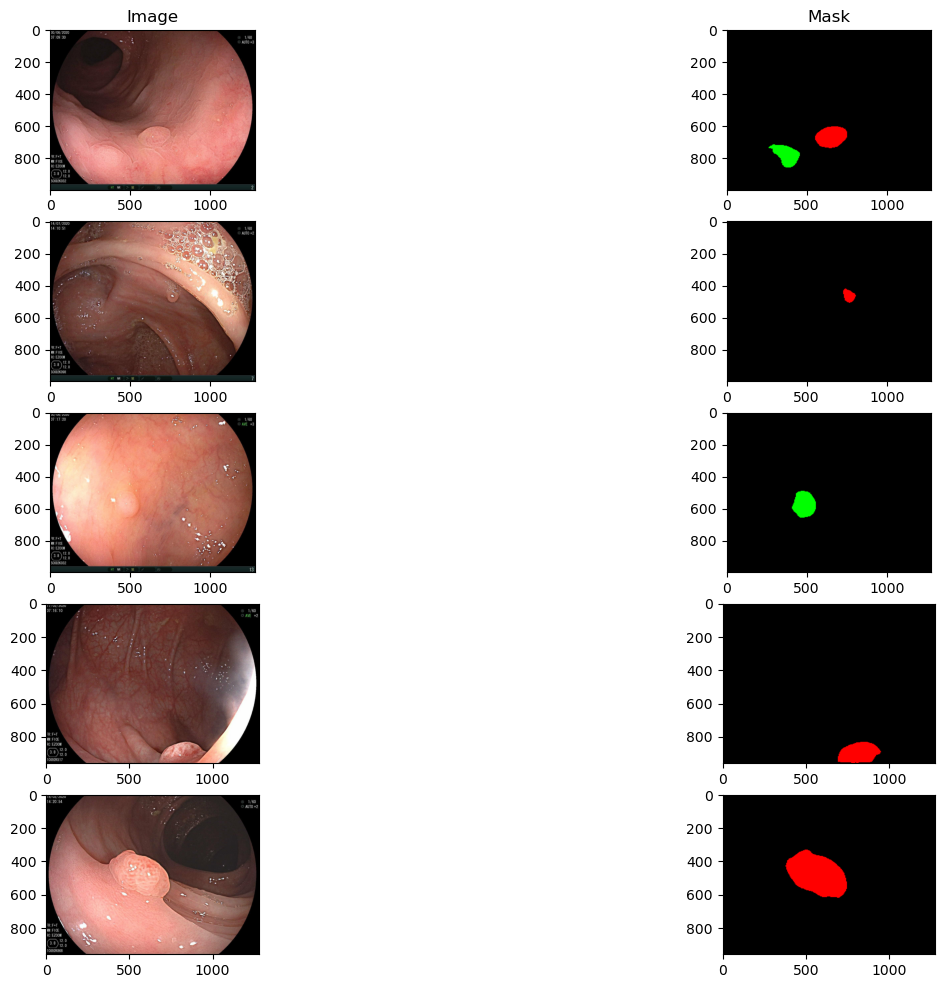

In [147]:
import random
n=5
fig,ax=plt.subplots(n,2,figsize=(16,12))
ax[0][0].set_title("Image")
ax[0][1].set_title("Mask")
img_list=os.listdir(test_dir_path)
mask_list=os.listdir(predict_dir_path)
random_ind=random.sample(range(0,len(img_list)),k=n)
for c,i in enumerate(random_ind):
    img_path=test_dir_path+img_list[i]
    mask_path=predict_dir_path+mask_list[i]
    img=Image.open(img_path)
    mask=Image.open(mask_path)
    ax[c][0].imshow(img)
    ax[c][1].imshow(mask)

In [148]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = predict_dir_path
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)

./data/test/predicted_mask/019410b1fcf0625f608b4ce97629ab55.png
./data/test/predicted_mask/02fa602bb3c7abacdbd7e6afd56ea7bc.png
./data/test/predicted_mask/0398846f67b5df7cdf3f33c3ca4d5060.png
./data/test/predicted_mask/05734fbeedd0f9da760db74a29abdb04.png
./data/test/predicted_mask/05b78a91391adc0bb223c4eaf3372eae.png
./data/test/predicted_mask/0619ebebe9e9c9d00a4262b4fe4a5a95.png
./data/test/predicted_mask/0626ab4ec3d46e602b296cc5cfd263f1.png
./data/test/predicted_mask/0a0317371a966bf4b3466463a3c64db1.png
./data/test/predicted_mask/0a5f3601ad4f13ccf1f4b331a412fc44.png
./data/test/predicted_mask/0af3feff05dec1eb3a70b145a7d8d3b6.png
./data/test/predicted_mask/0fca6a4248a41e8db8b4ed633b456aaa.png
./data/test/predicted_mask/1002ec4a1fe748f3085f1ce88cbdf366.png
./data/test/predicted_mask/1209db6dcdda5cc8a788edaeb6aa460a.png
./data/test/predicted_mask/13dd311a65d2b46d0a6085835c525af6.png
./data/test/predicted_mask/1531871f2fd85a04faeeb2b535797395.png
./data/test/predicted_mask/15fc656702fa6